## Time SERIES Prediction 
It is well know that Machine Learning techniques allow to predict and find patterns into our data. Linear regression, Random Forest, etc., are the most popular algorithms used for that. But, what if we want to predict how much an insurance company must to pay in claims in the followings months? Well you probably choose a linear regression technique for this, but the date time is a good parameter to create a linear regression? The answer is maybe. The problem is that our model using this standard techniques doesn't have the best accuracy. 

In this notebook i'll show how can we use the ARIMA algorithms in order to predict how much an insurance company will pay in claims by the followings moths.

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
import datetime 
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
pet=pd.read_csv('petdata.csv')

In [4]:
claim=pd.read_csv('claimdata.csv')

In [5]:
df=pd.merge(pet,claim,on='PetId')

In [6]:
df.head()

,PetId,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,ClaimId,ClaimDate,ClaimAmount
0,2,2014-12-20,NaN,Dog,French Bulldog,8 weeks to 12 months old,7633,2018-02-14,82.80
1,2,2014-12-20,NaN,Dog,French Bulldog,8 weeks to 12 months old,13987,2018-08-07,190.69
2,2,2014-12-20,NaN,Dog,French Bulldog,8 weeks to 12 months old,24729,2018-04-14,346.61
3,2,2014-12-20,NaN,Dog,French Bulldog,8 weeks to 12 months old,25317,2018-07-14,27.25
4,2,2014-12-20,NaN,Dog,French Bulldog,8 weeks to 12 months old,26643,2018-11-16,186.76


In [7]:
dog=df.loc[df['Species']=='Dog']


In [8]:
cat=df.loc[df['Species']=='Cat']

In [9]:
dog['ClaimDate'].min(), dog['ClaimDate'].max()

('2010-01-06', '2019-06-30')

In [10]:
cat['ClaimDate'].min(), cat['ClaimDate'].max()

('2010-02-16', '2019-06-30')

In [11]:

# importing label encoder
from sklearn.preprocessing import LabelEncoder

# creating a label encoder
le = LabelEncoder()


# label encoding for sex
# 0 for females and 1 for males
df['Species'] = le.fit_transform(df['Species'])

# label encoding for smoker
# 0 for smokers and 1 for non smokers
df['Breed'] = le.fit_transform(df['Breed'])

In [12]:
df.head()

,PetId,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,ClaimId,ClaimDate,ClaimAmount
0,2,2014-12-20,NaN,1,1,8 weeks to 12 months old,7633,2018-02-14,82.80
1,2,2014-12-20,NaN,1,1,8 weeks to 12 months old,13987,2018-08-07,190.69
2,2,2014-12-20,NaN,1,1,8 weeks to 12 months old,24729,2018-04-14,346.61
3,2,2014-12-20,NaN,1,1,8 weeks to 12 months old,25317,2018-07-14,27.25
4,2,2014-12-20,NaN,1,1,8 weeks to 12 months old,26643,2018-11-16,186.76


In [13]:
df=df.drop(['EnrollDate','CancelDate','AgeAtEnroll','ClaimId'],axis=1)
df.head()

,PetId,Species,Breed,ClaimDate,ClaimAmount
0,2,1,1,2018-02-14,82.80
1,2,1,1,2018-08-07,190.69
2,2,1,1,2018-04-14,346.61
3,2,1,1,2018-07-14,27.25
4,2,1,1,2018-11-16,186.76


In [14]:
df.isnull().sum()

PetId          0
Species        0
Breed          0
ClaimDate      0
ClaimAmount    0
dtype: int64

In [15]:
df = df.groupby('ClaimDate')['ClaimAmount'].sum().reset_index()

In [16]:

df['ClaimDate'] = pd.to_datetime(df['ClaimDate'])


In [17]:
df = df.set_index('ClaimDate')
df.index

DatetimeIndex(['2010-01-06', '2010-01-15', '2010-01-20', '2010-01-23',
               '2010-01-27', '2010-01-29', '2010-01-30', '2010-02-10',
               '2010-02-12', '2010-02-15',
               ...
               '2019-06-21', '2019-06-22', '2019-06-23', '2019-06-24',
               '2019-06-25', '2019-06-26', '2019-06-27', '2019-06-28',
               '2019-06-29', '2019-06-30'],
              dtype='datetime64[ns]', name='ClaimDate', length=3121, freq=None)

Our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3121 entries, 2010-01-06 to 2019-06-30
Data columns (total 1 columns):
ClaimAmount    3121 non-null float64
dtypes: float64(1)
memory usage: 48.8 KB


In [19]:
y = df['ClaimAmount'].resample('MS').mean()

In [20]:
y['2019':]

ClaimDate
2019-01-01    11088.193226
2019-02-01     8904.427143
2019-03-01     9881.851613
2019-04-01    10551.385667
2019-05-01    12127.300000
2019-06-01    11425.735333
Freq: MS, Name: ClaimAmount, dtype: float64

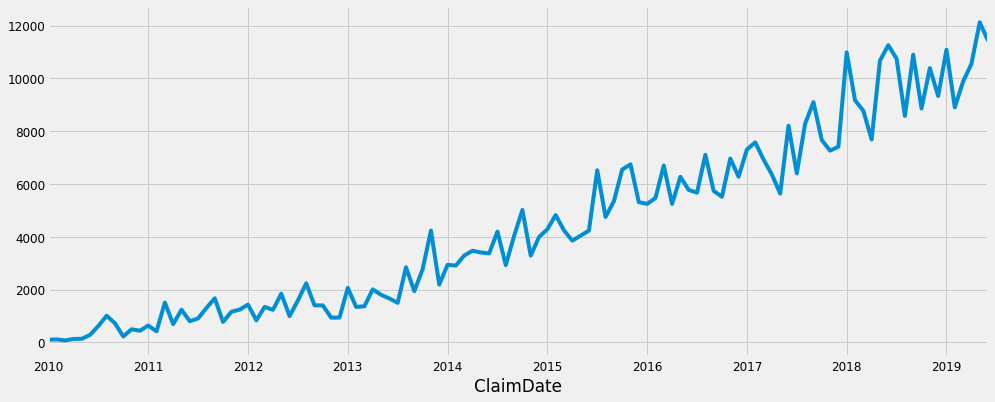

In [21]:
y.plot(figsize=(15, 6))
plt.show()

# Time series forecasting with ARIMA

We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.
ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [22]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [23]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue



ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2272.6111168328516
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1995.372493737423
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1780.0631543346874
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1569.1658054675306
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1741.648242493141
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1718.183158542527
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1579.042898387155
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1532.9955814155412
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2185.5844917103923
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1849.0998014130798
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1739.7121066703114
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1539.4447308701651
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1739.8046718645878
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1697.2481823386877
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1571.768320913697
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1517.5981436540121
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1882.785785668367
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1690.599154424715

In [24]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0386      0.144     -0.267      0.789      -0.322       0.245
ma.L1         -0.8425      0.069    -12.159      0.000      -0.978      -0.707
ar.S.L12      -0.4639      0.093     -5.005      0.000      -0.646      -0.282
sigma2      1.052e+06   1.46e+05      7.200      0.000    7.66e+05    1.34e+06


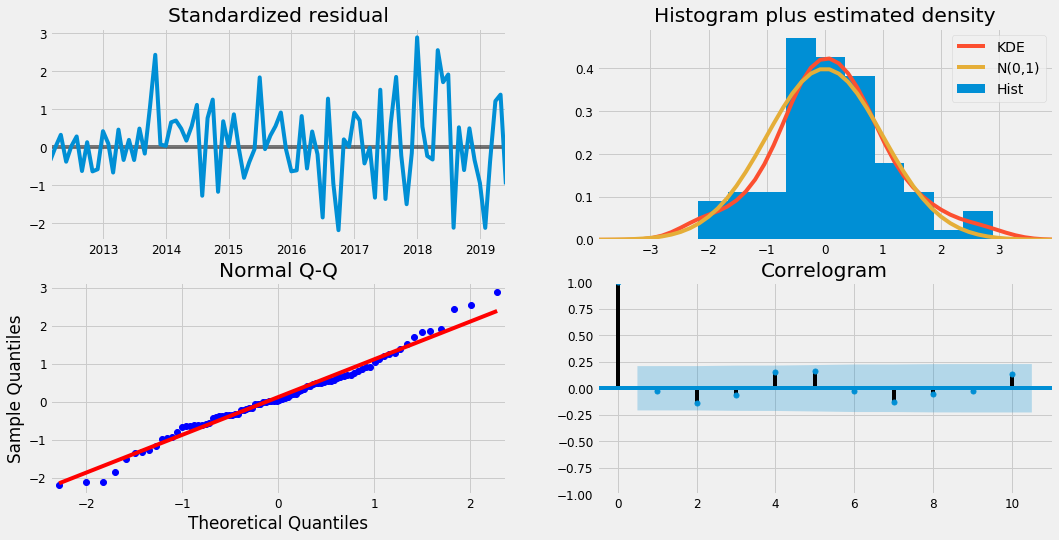

In [25]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.
The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.
The residuals over time (top left plot) don’t display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.
Those observations lead us to conclude that our model produces a satisfactory fit that could help us understand our time series data and forecast future values.

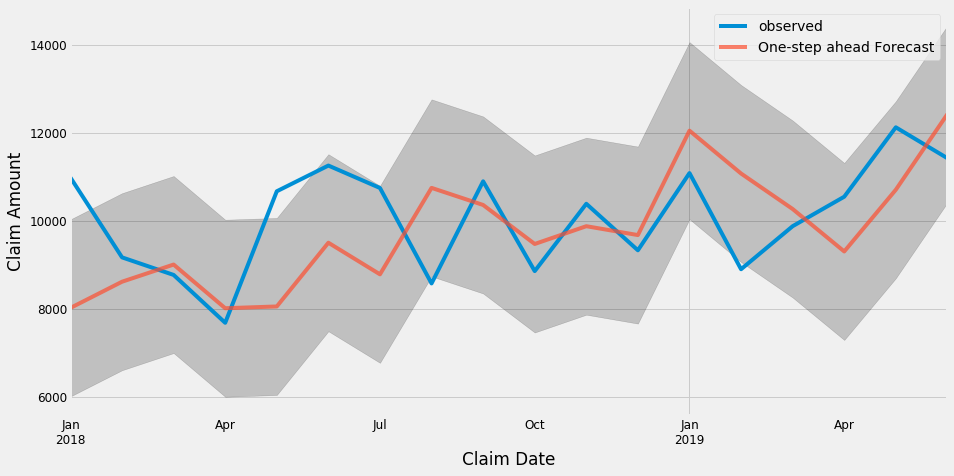

In [48]:
pred = results.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Claim Date')
ax.set_ylabel('Claim Amount')
plt.legend()
plt.show()

In [49]:
y_forecasted = pred.predicted_mean
y_truth = y['2018-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 2172853.69


In [50]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

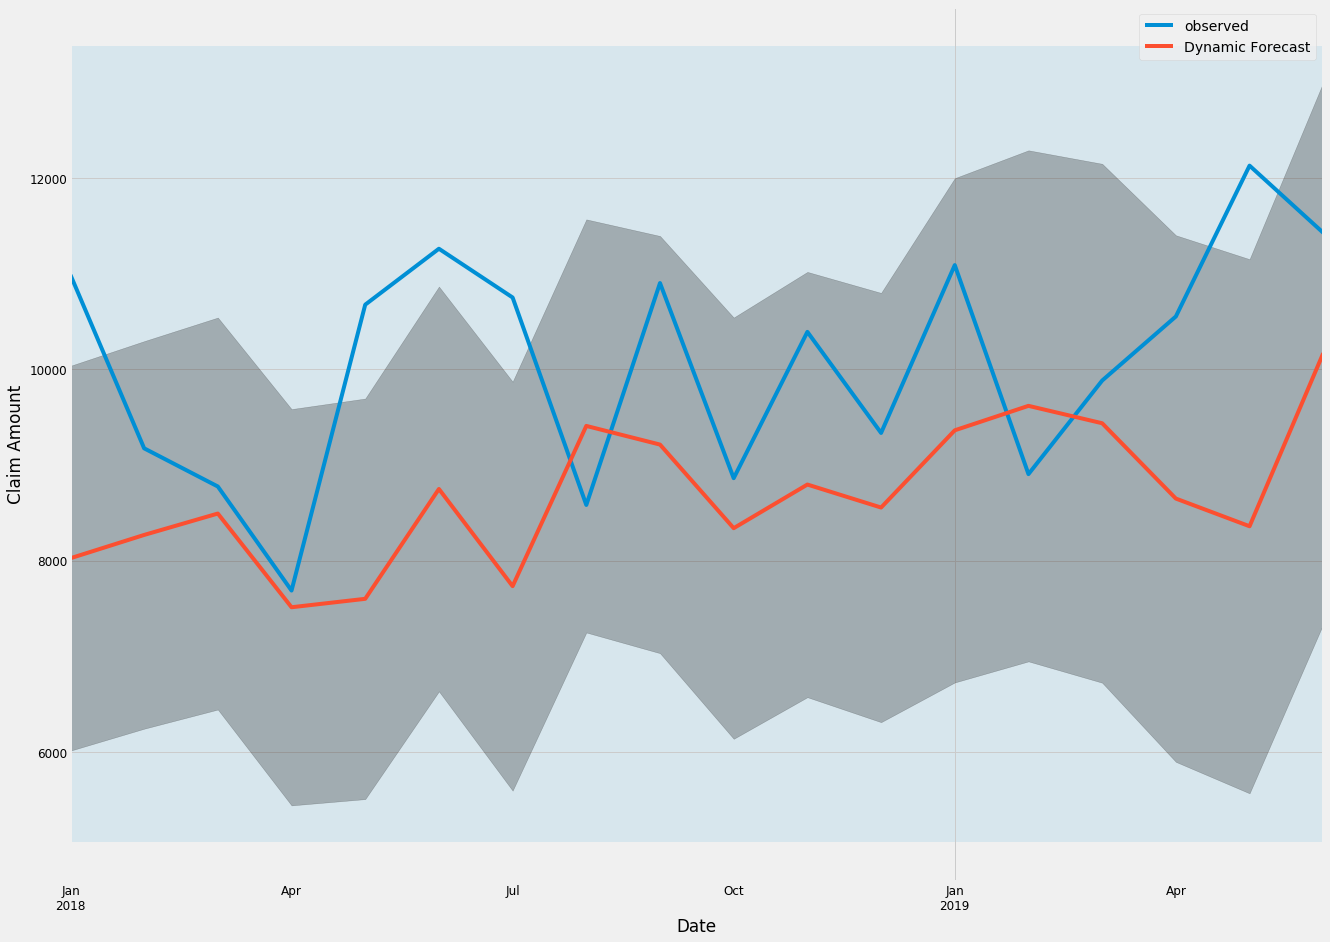

In [52]:
ax = y['2018':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Claim Amount')

plt.legend()
plt.show()

In [51]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['2018-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 3587418.96


In [44]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=10)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

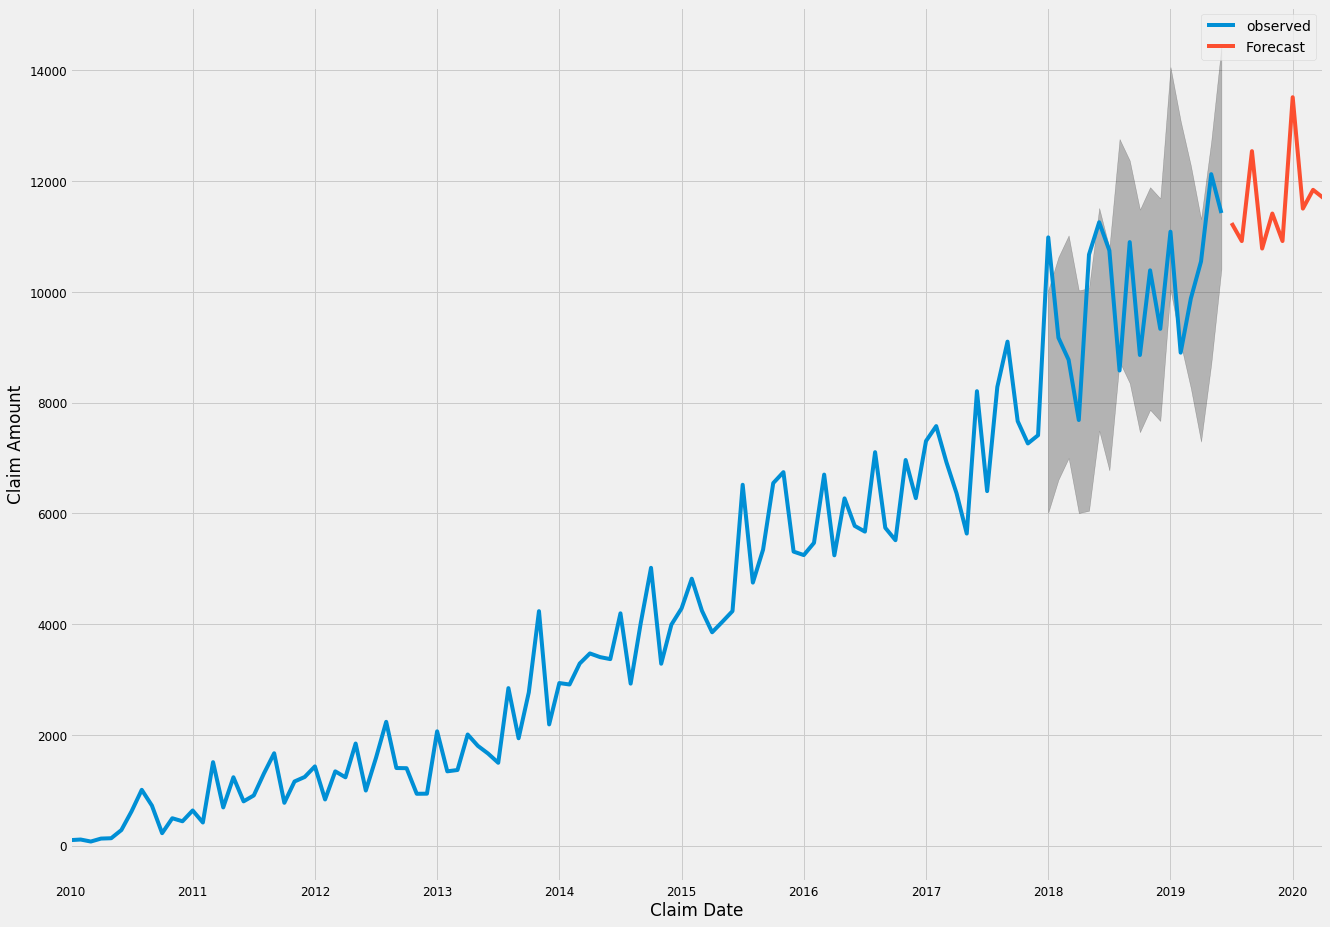

In [53]:
ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Claim Date')
ax.set_ylabel('Claim Amount')

plt.legend()
plt.show()